**Intensidad de uso del agua subterránea**

In [2]:
rm(list = ls())
libraries <- c("openxlsx",
               "janitor", 
               "tidyverse")

installed_packages <- rownames(installed.packages())
libraries_to_install <- setdiff(libraries, installed_packages)

if (length(libraries_to_install) > 0) {
  install.packages(libraries_to_install)
}

lapply(libraries, library, character.only = TRUE)


Adjuntando el paquete: 'janitor'


The following objects are masked from 'package:stats':

    chisq.test, fisher.test


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[[1]]
[1] "openxlsx"  "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "janitor"   "openxlsx"  "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[3]]
 [1] "lubridate" "forcats"   "stringr"   "dplyr"     "purrr"     "readr"    
 [7] "tidyr"     "tibble"    "ggplot2"   "tidyverse" "janitor"   "openxlsx" 
[13] "stats"     "graphics"  "grDevices" "utils"     "datasets"  "methods"  
[19] "base"

In [3]:
# URL del archivo
#Url de la base: 
url <- "http://dgeiawf.semarnat.gob.mx:8080/ibi_apps/WFServlet?IBIF_ex=d3_agua02_01_R1&VL_FORMAT=EXL2K&IBIC_user=c24&IBIC_pass=c24"
temp_file <- tempfile(fileext = ".xls")
options(timeout = 800)
download.file(url, temp_file, mode = "wb")
file.rename(temp_file, "ext_rec_acui.xls")

[1] TRUE

In [9]:
#CAMBIO DE ALMACENAMIENTO----
#hectómetros cúbicos por año
ext_rec_ac<- readxl::read_excel("ext_rec_acui.xls", skip = 2)|>
  #slice(1218:1236)|> #Seleccionando solamente la ciudad de méxico
  slice(1294:1312) |>
  janitor::clean_names()|>
  filter(ano %in% c(2003,2005,2007,2009,2011,2013,2015,2017,2019,2021,2023))

ext_rec_acui<-ext_rec_ac|>
  mutate(intensidad = (volumen_de_extraccion/volumen_de_recarga)*100)|>
  select(ano, intensidad)|>
  mutate(tipo = "Observado",
          ano = as.numeric(ano))

ext_rec_acui


ano,intensidad,tipo
<dbl>,<dbl>,<chr>
2003,106.73312,Observado
2005,98.79854,Observado
2007,98.25698,Observado
2009,80.24756,Observado
2011,79.08343,Observado
2013,83.39841,Observado
2015,83.91984,Observado
2017,85.20615,Observado
2019,85.20615,Observado


In [10]:
ext_rec_acui_2023 <- ext_rec_acui |> filter(ano == 2023)
ext_rec_acui_2003 <- ext_rec_acui |> filter(ano == 2003)

In [12]:
##ESCENARIOS TENDENCIALES 2030,2035,2045
# Tasa de variación
tcma<-((ext_rec_acui_2023$intensidad /ext_rec_acui_2003$intensidad)^(1/(2023-2003)) - 1) 
tcma

intensidad_base <- ext_rec_acui |>
  filter(ano == 2023) |>
  pull(intensidad)

# Años a proyectar
años <- c(2030, 2035, 2045)
año_base <- 2023

tendencia_base <- data.frame(ano = años,
                             intensidad = round(intensidad_base * (1 + 1/3*tcma ) ^ (años - año_base), 2),
                             tipo = "Inercial")


tendecia_deseable<-data.frame(ano = años,
                              intensidad = round(intensidad_base * (1 + -1/2*tcma) ^ (años - año_base), 2),
                              tipo = "Deseable")


tendecia_transformadora <-data.frame(ano = años,
                                     intensidad = round(intensidad_base * (1 + tcma*-1.5) ^ (años - año_base), 2),
                                     tipo = "Transformador")


intensidad_tendencias <- ext_rec_acui|>
  bind_rows(tendencia_base,tendecia_deseable, 
            tendecia_transformadora)|>
  select(ano, intensidad, tipo)

intensidad_tendencias

[1] -0.002364563

ano,intensidad,tipo
<dbl>,<dbl>,<chr>
2003,106.73312,Observado
2005,98.79854,Observado
2007,98.25698,Observado
2009,80.24756,Observado
2011,79.08343,Observado
2013,83.39841,Observado
2015,83.91984,Observado
2017,85.20615,Observado
2019,85.20615,Observado


In [13]:
lineas <- bind_rows(data.frame(ano = c(2023, 2030),
                               intensidad = c(intensidad_tendencias$intensidad[intensidad_tendencias$ano == 2023 & intensidad_tendencias$tipo == "Observado"],
                                              intensidad_tendencias$intensidad[intensidad_tendencias$ano == 2030 & intensidad_tendencias$tipo == "Inercial"]),
                               tipo = "Inercial"),
                    data.frame(ano = c(2023, 2030),
                               intensidad = c(intensidad_tendencias$intensidad[intensidad_tendencias$ano == 2023 & intensidad_tendencias$tipo == "Observado"], 
                                              intensidad_tendencias$intensidad[intensidad_tendencias$ano == 2030 & intensidad_tendencias$tipo == "Deseable"]),
                               tipo = "Deseable"), 
                    data.frame(ano = c(2023, 2030),
                               intensidad = c(intensidad_tendencias$intensidad[intensidad_tendencias$ano == 2023 & intensidad_tendencias$tipo == "Observado"], 
                                              intensidad_tendencias$intensidad[intensidad_tendencias$ano == 2030 & intensidad_tendencias$tipo == "Transformador"]),
                               tipo = "Transformador"))


paleta_colores <- c("Observado" = "#9F2241",
                    "Inercial" = "#cfcfcf" ,
                    "Deseable" = "#027A35", 
                    "Transformador" = "#AC6D14")

linetypes <- c("Observado" = "solid",
               "Inercial" = "dotdash",
               "Deseable" = "dotdash", 
               "Transformador" = "dotdash")

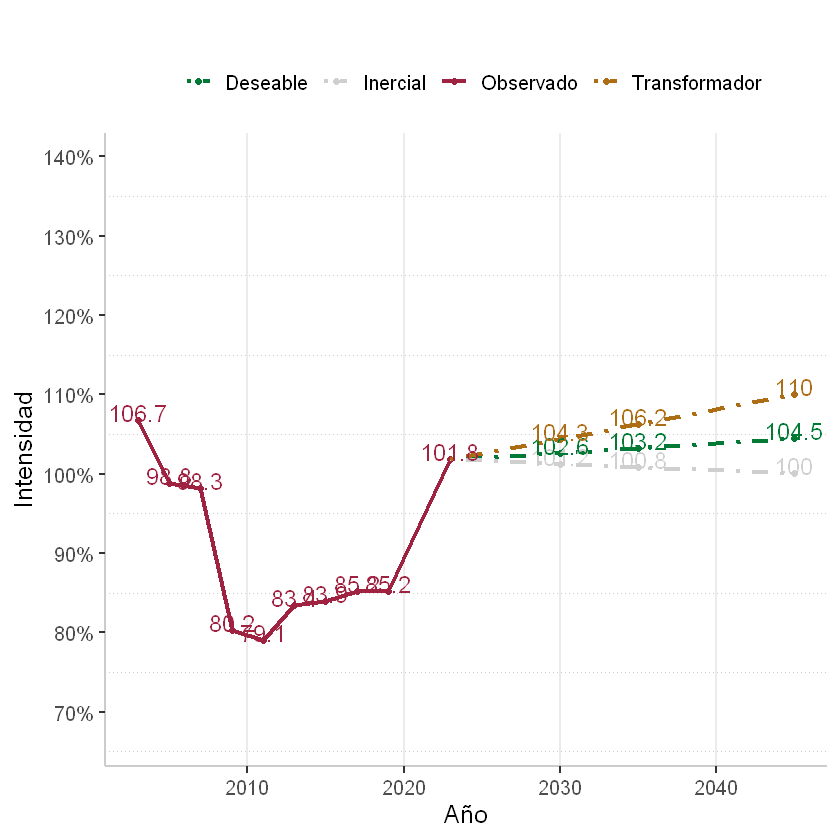

In [14]:
# Gráfico con etiquetas y eje Y personalizado
ggplot(intensidad_tendencias, aes(x = ano, y = intensidad, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
  geom_line(data = lineas, aes(x = ano, y = intensidad, group = tipo), linewidth = 1.2) +
  geom_text(aes(label = round(intensidad, 1)),
            position = position_nudge(y = 1),
            size = 5, show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(intensidad_tendencias$intensidad, na.rm = TRUE) + 150, by = 10),
                     labels = function(x) paste0(x, "%"),
                     expand = expansion(mult = c(0.5,1))) +
  labs(title = "",
       x = "Año",
       y = "Intensidad",
       color = "",
       linetype = "") +
  theme_bw(base_size = 15) +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 010))



ggsave("Intensidad de uso del agua subterranea.png", width = 8, height = 5, dpi = 300)